In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

This note book is a step by step walk through of the manifold capacity and geometries algorithm in Chou2025b (algorithm 2).  

I will begin by creating two point clouds in 2D space clearly visible separate and the walk through the algorithm step by step to understand it. 

Having it in 2D will make all the vectors easily visible to understand how the algorithm is working. 

In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from cvxopt import matrix, solvers
from jaxopt import OSQP

### Create Data
Randomly sample from two means.


In [3]:
mu1, mu2 = jnp.array([2,2]), jnp.array([-2,-2])
sigma = jnp.array([[1,0],[0,1]])
key = jax.random.PRNGKey(42)
cloud1_key, cloud2_key, key = jax.random.split(key, 3)

In [4]:
n_points_per_cloud = 200
cloud1 = jax.random.multivariate_normal(cloud1_key, mu1, sigma, n_points_per_cloud)
cloud2 = jax.random.multivariate_normal(cloud2_key, mu2, sigma, n_points_per_cloud)

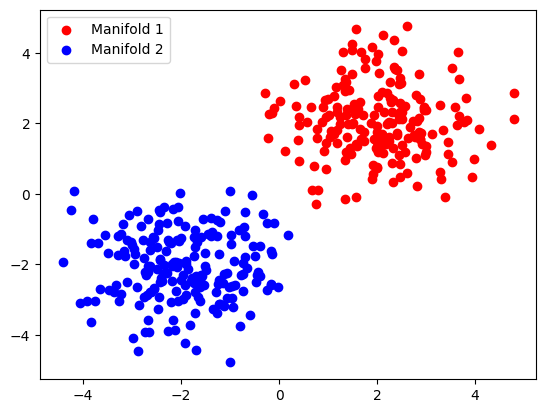

In [5]:
plt.scatter(cloud1[:,0], cloud1[:,1], label='Manifold 1', color='r')
plt.scatter(cloud2[:,0], cloud2[:,1], label='Manifold 2', color='b')
plt.legend()
plt.show()

#### inputs
P point clouds = 2 point clouds
M points sampled from each cloud
n_t number of t and y samples for expectation

In [6]:
M = 50

In [7]:
# Randomly sample M points from each cloud
c1_m_key, c2_m_key, key = jax.random.split(key, 3)
cloud1_M = jax.random.choice(c1_m_key, cloud1, (M,), axis=0)
cloud2_M = jax.random.choice(c2_m_key, cloud2, (M,), axis=0)

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cloud1[:,0],y=cloud1[:,1],mode='markers', name='Cloud 1'))
fig.add_trace(go.Scatter(x=cloud1_M[:,0], y=cloud1_M[:,1],mode='markers',  name="C1_M pnts"))
fig.update_layout(width=400, height=300,    
                  margin=dict(
                            l=30,
                            r=30,
                            b=50,
                            t=50,
                            pad=2
                        ),)
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cloud1_M[:,0], y=cloud1_M[:,1],mode='markers',  name="C1_M pnts"))
fig.add_trace(go.Scatter(x=cloud2_M[:,0], y=cloud2_M[:,1],mode='markers',  name="C2_M pnts"))
fig.update_layout(width=400, height=300,    
                  margin=dict(
                            l=30,
                            r=30,
                            b=50,
                            t=50,
                            pad=2
                        ),)
fig.show()

In [10]:
"""
Step 1:
Sample anchor points
loop through n_t times
    random vector: this projects the activity into random direction?
    random dichotomy: this randomly labels each cloud.
"""

t_mu = jnp.array([0,0])
t_sigma = jnp.array([[1,0],[0,1]])
y_dichotomies = jnp.array([[-1,1],[1,-1]])
n_dichotomies = 2

# constants
A = jnp.eye(2)
h = jnp.zeros((2*M, 1))
n_t = 100

qp = OSQP()

anchor_points = jnp.zeros((2, n_t, 2))
y_ks = jnp.zeros((2,n_t))

for k in range(0,n_t):
    k_key = jax.random.fold_in(key, k)
    t_key, y_key = jax.random.split(k_key, 2)
    t_k = jax.random.multivariate_normal(t_key, t_mu, t_sigma, (1,)).T
    y_k = jax.random.choice(y_key, y_dichotomies, (1,), axis=0).squeeze(0)
    # print(f"{y_k=}")
    y_ks = y_ks.at[:,k].set(y_k)
    q_t = -1*t_k
    # elementwise multiplication of y_k and M samples
    G = jnp.concatenate([y_k[0] * cloud1_M, y_k[1] * cloud2_M]) # will be PM x N
    # print(f"{A.shape=}\n{q_t.shape=}\n{G.shape=}\n{h.shape=}")
    # qp_output = solvers.qp(matrix(A),
    #                         matrix(q_t),
    #                           matrix(G), 
    #                           matrix(h))
    sol = qp.run(params_obj=(A, q_t), params_eq=None, params_ineq=(G, h)).params
    z_dual = sol.dual_ineq
    # print(f"{z_dual.shape=}")
    for i in range(2):
        # print(f"Index range: [{i*M}:{(i+1)*M-1}]")
        sv_i_k = ((z_dual[i*M:(i+1)*M-1].T @ G[i*M:(i+1)*M-1,:]) / (jnp.sum(z_dual[i*M:(i+1)*M-1]) + 1e-9)).squeeze()
        # print(f"{sv_i_k.shape=}")
        anchor_points = anchor_points.at[i,k,:].set(sv_i_k)

In [11]:
# anchor_points

In [12]:
# print(f"{anchor_points=}")
print(f"{anchor_points.shape=}")

anchor_points.shape=(2, 100, 2)


In [13]:
# plot anchor points
plot_anchor_points_c1 =  (anchor_points[0,:,:].T * y_ks[0,:]).T
plot_anchor_points_c2 = (anchor_points[1,:,:].T * y_ks[1,:]).T
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_anchor_points_c1[:,0],y=plot_anchor_points_c1[:,1],mode='markers', name='c1'))
fig.add_trace(go.Scatter(x=plot_anchor_points_c2[:,0],y=plot_anchor_points_c2[:,1],mode='markers', name='c2'))
fig.add_trace(go.Scatter(x=cloud1_M[:,0], y=cloud1_M[:,1],mode='markers',  name="C1_M pnts"))
fig.add_trace(go.Scatter(x=cloud2_M[:,0], y=cloud2_M[:,1],mode='markers',  name="C2_M pnts"))
fig.update_layout(width=400, height=300,    
                  margin=dict(
                            l=30,
                            r=30,
                            b=50,
                            t=50,
                            pad=2
                        ),)
fig.show()


In [ ]:
# step 2: anchor center gram matrix
# take mean over n_t, axis=1 for anchor_points
s_0 = jnp.nanmean(anchor_points, axis=1) # shape 2 x 2; p classes, N features
print(f"{s_0}")
#these seem to be small because of our low dimensional data/test case.

[[-0.20675331  0.14233589]
 [-0.17302108  0.01618874]]


In [15]:
G_0_1 = jnp.outer(s_0[0], s_0[0])
G_0_2 = jnp.outer(s_0[1], s_0[1])
G_0 = jnp.sum(jnp.stack([G_0_1, G_0_2], axis=0), axis=0)
print(G_0)


[[ 0.07268322 -0.03222941]
 [-0.03222941  0.02052158]]


In [17]:
# step 3: spearate center and axis anchor parts
G_1 = jnp.zeros((n_t, 2))
t_1 = jnp.zeros((n_t))
for k in range(n_t):
    # first cluster
    s_0_1_k = anchor_points[0,k,:] - s_0[0,:]
    s_1_1_k = anchor_points[1,k,:] - s_0[1,:]
